# Introduction to Data Science（HW1）

In [1]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk1.8.0_202"

In [2]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf




Let's initialize the Spark context.


In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
import pyspark
from pyspark import SparkContext as sc
from pyspark import SparkConf
conf=SparkConf().setAppName("miniProject").setMaster("local[*]")
sc=SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [5]:
spark

# Qustion 1：Know More about Vietnam War

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

In [6]:
Bombing_Operations = spark.read.json("Bombing_Operations.json.gz")
Aircraft_Glossary = spark.read.json("Aircraft_Glossary.json.gz")

**1.   Select 3 sample (random choose) of Bombing_Operations and save the result as TempTable**

**(10 point)**

In [7]:
# YOUR CODE HERE
tmptable=Bombing_Operations.take(3)
print(tmptable)

[Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1971-06-05', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='TAN SON NHUT', TargetCountry='CAMBODIA', TimeOnTarget=1005.0, WeaponType=None, WeaponsLoadedWeight=0), Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1972-12-26', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='NAKHON PHANOM', TargetCountry='SOUTH VIETNAM', TimeOnTarget=530.0, WeaponType=None, WeaponsLoadedWeight=0), Row(AirCraft='RF-4', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1973-07-28', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='UDORN AB', TargetCountry='LAOS', TimeOnTarget=730.0, WeaponType=None, WeaponsLoadedWeight=0)]



**2. Count the top 5 countries considered to be the most Targetcountry in the Bombing_Operations data set, and count their total TimeOnTarget**

**(10 point)**

In [149]:
# YOUR CODE HERE
TargetCountry_counts = Bombing_Operations.groupBy("Targetcountry")\
                                        .agg(count("*").alias("Count"),sum("TimeOnTarget").alias("TimeOnTarget"))\
                                        .sort(desc("Count"))                         
TargetCountry_counts.show()



+--------------+-------+-------------+
| Targetcountry|  Count| TimeOnTarget|
+--------------+-------+-------------+
| SOUTH VIETNAM|2172403|1.778017197E9|
|          LAOS|1254695|1.162924419E9|
| NORTH VIETNAM| 694269| 6.05604794E8|
|      CAMBODIA| 218788| 1.69886781E8|
|      THAILAND|  60486|  4.5229813E7|
|WESTPAC WATERS|     74|      18775.0|
|       UNKNOWN|     59|      35939.0|
|   PHILLIPINES|      1|          0.0|
+--------------+-------+-------------+



**3. draw a bar graph of the number of different Aircraft types（y）in different TargetCountry （x）(legend: Aircraft type)**

**（20 point）**

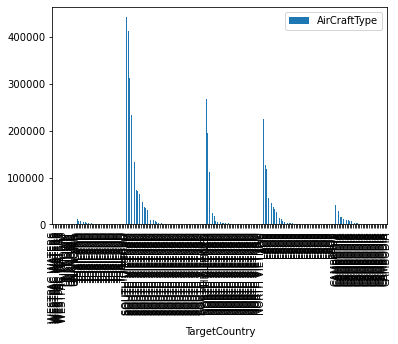

In [165]:
# YOUR CODE HERE
frame_joined=Bombing_Operations.join(Aircraft_Glossary, Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)
frame_selected=frame_joined.selectExpr(["TargetCountry","AirCraftType"])
teminal_frame=frame_selected.groupBy("AirCraftType","TargetCountry")\
                            .agg(count("*").alias("typecount"))\
                            .sort(desc("TargetCountry"),desc("typecount"))\
                            .toPandas()
pl=teminal_frame.plot(kind="bar",x="TargetCountry",y="typecount",label="AirCraftType")

plt.legend(loc='best')


**4. Use the \<Spark SQL\> to select the weapon whose Aircraft type is'F-105' in Bombing_Operations data**

**(20 point)**

In [27]:
# YOUR CODE HERE

Bombing_Operations.registerTempTable("Bombing_Operations")

# sql select
query = """
SELECT WeaponType as Weapon, count(*) as Count
FROM Bombing_Operations
WHERE AirCraft =="F-105"
GROUP BY WeaponType
ORDER BY Count DESC
"""

missions_counts = spark.sql(query)
missions_counts.show()

+--------------------+-----+
|              Weapon|Count|
+--------------------+-----+
|                null|46846|
|      750LB GP M-117|26843|
|                M-61|11964|
|      500LB GP MK-82| 9952|
|           CBU-24/29| 8036|
|              SHRIKE| 6743|
|    AGM-45A SHRIKE-3| 4808|
|       2.75IN HE RKT| 3916|
|AGM-72 STD AR MISSLE| 2712|
|        2000LB MK-84| 2390|
|        3000LB M-118| 2308|
|          SIDEWINDER| 2232|
|        1000LB MK-83| 2209|
|        LAU-3A/AERO7| 2028|
|MK 82 GP BOMB (50...| 1799|
|           BULLPUP B| 1248|
|      750LB BLU-1/27|  570|
|              CBU 30|  565|
|       500LB GP M-64|  440|
|      STD/ARM AGM-78|  324|
+--------------------+-----+
only showing top 20 rows



**5. Count aircraft  from January to December where Take off Location as'TAN SON NHUT' in Bombing_Operations data, and plot the result.**

**（20 point）**

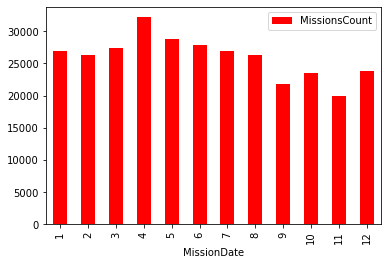

In [79]:
# selectExpr() select columns ; to_date() datatype:date
missions_countries = Bombing_Operations.selectExpr(["month(MissionDate) as MissionDate", "TakeoffLocation"])
missions_countries
missions_by_date = missions_countries\
                    .select("MissionDate").where(col("TakeoffLocation")=='TAN SON NHUT')\
                    .groupBy(["MissionDate"])\
                    .agg(count("*").alias("MissionsCount"))\
                    .sort(asc("MissionDate")).toPandas()
missions_by_date.head(12)

pl=missions_by_date.plot(kind="bar",x="MissionDate",y="MissionsCount",color="red")

**6. Please select the aircraft whose WeaponType is None and groupby each Target country**

**（10 point）**

In [148]:
pure=Bombing_Operations.where("WeaponType is Null")
temp=pure.selectExpr("AirCraft","TargetCountry")
data=temp.groupBy("TargetCountry","AirCraft").agg(count("*")).sort(desc("TargetCountry"))
data2=data.selectExpr("TargetCountry","AirCraft")
data2.show(50)

+--------------+---------+
| TargetCountry| AirCraft|
+--------------+---------+
|WESTPAC WATERS|     RA-5|
|WESTPAC WATERS|      F-4|
|WESTPAC WATERS|      F-8|
|WESTPAC WATERS|      A-1|
|WESTPAC WATERS|      A-7|
|WESTPAC WATERS|      A-4|
|WESTPAC WATERS|    EKA-3|
|WESTPAC WATERS|     EA-1|
|WESTPAC WATERS|   EC-121|
|WESTPAC WATERS|      A-6|
|WESTPAC WATERS|      C-1|
|       UNKNOWN|     TA-4|
|       UNKNOWN|     RF-4|
|       UNKNOWN|      F-4|
|       UNKNOWN|    F-100|
|       UNKNOWN|    EB-66|
|       UNKNOWN|      A-4|
|       UNKNOWN|    OV-10|
|       UNKNOWN|    F-105|
|       UNKNOWN|      F-8|
|       UNKNOWN|      A-7|
|       UNKNOWN|      A-6|
|      THAILAND|     EA-6|
|      THAILAND|     B-57|
|      THAILAND|    QU-22|
|      THAILAND|   HC-130|
|      THAILAND|    AC-47|
|      THAILAND|   YQU-22|
|      THAILAND|   AC-119|
|      THAILAND|    CH-46|
|      THAILAND|    RB-66|
|      THAILAND|NOT CODED|
|      THAILAND|    EB-66|
|      THAILAND|      A-6|
|

# Question 2：Instacart Market Basket Analysis（10 point）

The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

https://www.kaggle.com/c/instacart-market-basket-analysis/data

**YOUR TASK**

Use the Spark Dataframe API to join 'products' and 'orders', so that you will be able to see the product names in each transaction (and not only their ids). Then, group by the orders by 'order_id' to obtain one row per basket (i.e., set of products purchased together by one customer).

In [115]:
products = spark.read.csv('products.csv', header=True, inferSchema=True)
orders = spark.read.csv('order_products__train.csv', header=True, inferSchema=True)

In [151]:
# YOUR CODE HERE
joined = products.join(orders,products.product_id==orders.product_id)

data = joined.groupby("order_id")\
            .agg((count("add_to_cart_order")+sum("reordered")).alias("order"))\
            .sort(desc("order"))
data.show()

+--------+-----+
|order_id|order|
+--------+-----+
| 2813632|  145|
|  653280|  143|
|  312611|  138|
| 2869702|  137|
| 2395604|  130|
| 1395075|  128|
| 1355077|  128|
|  341238|  126|
| 1388761|  125|
|  484152|  124|
| 2793449|  123|
| 2841309|  123|
| 2682845|  121|
| 1747908|  121|
|  736120|  119|
| 1964627|  119|
|  949182|  117|
|  181928|  115|
| 3313623|  114|
|   45138|  113|
+--------+-----+
only showing top 20 rows

